In [ ]:
!pip install rdkit transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 27.4 MB/s eta 0:00:00


#Pipeline completo

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem
from rdkit.Chem import BRICS
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
import torch
import seaborn as sns

##SMILES

In [ ]:
df = pd.read_csv("/content/curated_PrimaryOdor.csv")
smiles_df = pd.DataFrame()

# Copy scaffolds to new DataFrame
smiles_df['standardized_smiles'] = df['standardized_smiles']

In [ ]:
# Load pre-trained ChemBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to generate ChemBERTa embeddings from SMILES
def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings as the molecular embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

for i in range(1, 6):  # Assuming there are up to 5 odor columns
    col_name = f'odor_{i+1}'
    smiles_df[col_name] = df[col_name]

# Create 'combined_odors' column
odor_columns = [col for col in smiles_df.columns if col.startswith('odor_')]
smiles_df['combined_odors'] = smiles_df[odor_columns].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Apply smiles_to_embedding function to each SMILES in the dataset
smiles_df['embedding'] = smiles_df['standardized_smiles'].apply(smiles_to_embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
X = np.array(smiles_df['embedding'].tolist())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Determine top 5 most common odors
top_n = 5
odor_counts = smiles_df[odor_columns].apply(pd.Series.value_counts).sum(axis=1)
top_odors = odor_counts.nlargest(top_n).index.tolist()

# Group data points by top 5 odors using K-means clustering as an example
odor_groups = {}
for odor in top_odors:
    label_indices = smiles_df['combined_odors'].str.contains(odor)
    X_label = X_pca[label_indices]
    odor_groups[odor] = X_label

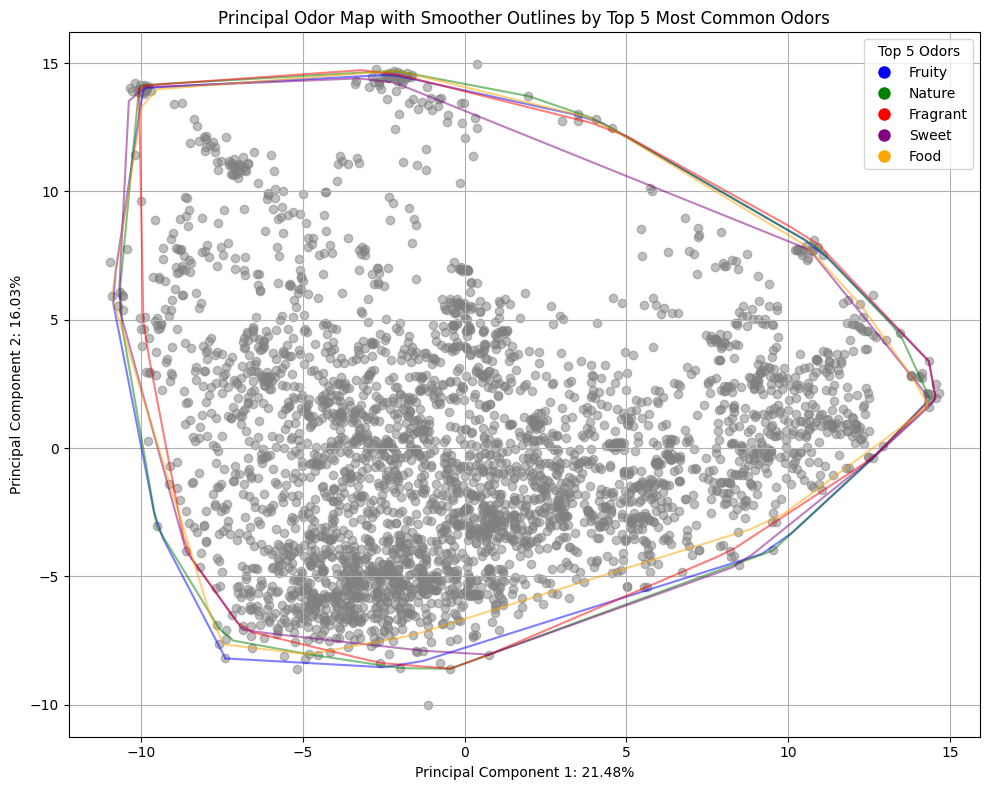

In [ ]:
# Define colors for plotting outlines
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot PCA results with gray points and smoother outlines for each top odor
plt.figure(figsize=(10, 8))

# Plot gray points
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.5, label='Other Odors')

# Plot smoother outlines for each top odor
for i, (odor, X_label) in enumerate(odor_groups.items()):
    # Calculate convex hull for the group
    hull = ConvexHull(X_label)

    # Extract points from convex hull
    points = X_label[hull.vertices]

    # Duplicate the last point to close the outline
    points = np.vstack([points, points[0]])

    # Interpolate between points for smoother outline
    t = np.arange(points.shape[0])
    interp = np.linspace(0, t.max(), 100)
    x_vals = np.interp(interp, t, points[:, 0])
    y_vals = np.interp(interp, t, points[:, 1])

    # Plot the interpolated outline
    plt.plot(x_vals, y_vals, color=colors[i], alpha=0.5, label=odor)

# Create legend for top 5 odors
legend_handles = []
for i, odor in enumerate(top_odors):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=odor))

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend
plt.legend(handles=legend_handles, title='Top 5 Odors', loc='upper right')

plt.title('Principal Odor Map with Smoother Outlines by Top 5 Most Common Odors')
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.grid(True)
plt.tight_layout()
plt.show()

##BRICS

In [ ]:
df = pd.read_csv("/content/curated_PrimaryOdor.csv")

# Function to extract scaffolds using RDKit (it extracts murcko-scaffolds)
def extract_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

def scaffold_brics(smiles):
  mol = Chem.MolFromSmiles(smiles)
  brics_fragments = BRICS.BreakBRICSBonds(mol)
  fragment_smiles = [Chem.MolToSmiles(frag) for frag in Chem.GetMolFrags(brics_fragments, asMols=True)]
  return fragment_smiles

# Apply scaffold extraction to each SMILES in the dataset
df['scaffold'] = df['standardized_smiles'].apply(scaffold_brics)

# Create a new DataFrame for scaffolds and labels
scaffold_df = pd.DataFrame()

# Copy scaffolds to new DataFrame
scaffold_df['scaffold'] = df['scaffold']

In [ ]:
scaffold_df

scaffold
0                                       [BrC=Cc1ccccc1]
1                      [[7*]=CCCC(C)(O)C#C, [7*]=C(C)C]
2           [[15*]C1(C#C)CCCCC1, [3*]O[3*], [1*]C(C)=O]
3     [[15*]C1CCCCC1([15*])C#C, [3*]O[3*], [1*]C(C)=...
4                                               [C#CCO]
...                                                 ...
3419  [[14*]c1ccco1, [8*]C[8*], [14*]c1cc([16*])co1,...
3420             [[14*]c1ccco1, [8*]C[8*], [9*]n1cccc1]
3421         [[14*]c1cccs1, [11*]SS[11*], [14*]c1cccs1]
3422                                          [c1cscn1]
3423                            [c1nc2c(o1)CCCCCCCCCC2]

[3424 rows x 1 columns]

In [ ]:
def max_length_element(lst):
    return max(lst, key=len)

# Apply the function to the 'scaffold' column to create a new column
scaffold_df['scaffold'] = scaffold_df['scaffold'].apply(max_length_element)

In [ ]:
scaffold_df

scaffold
0               BrC=Cc1ccccc1
1          [7*]=CCCC(C)(O)C#C
2          [15*]C1(C#C)CCCCC1
3     [15*]C1CCCCC1([15*])C#C
4                       C#CCO
...                       ...
3419      [14*]c1cc([16*])co1
3420             [14*]c1ccco1
3421             [14*]c1cccs1
3422                  c1cscn1
3423    c1nc2c(o1)CCCCCCCCCC2

[3424 rows x 1 columns]

##Chemberta

In [ ]:
# Load pre-trained ChemBERTa model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to generate ChemBERTa embeddings from SMILES
def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings as the molecular embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

# Assuming 'df' and 'scaffold_df' are already defined as in your original code
for i in range(1, 6):  # Assuming there are up to 5 odor columns
    col_name = f'odor_{i+1}'
    scaffold_df[col_name] = df[col_name]

# Create 'combined_odors' column
odor_columns = [col for col in scaffold_df.columns if col.startswith('odor_')]
scaffold_df['combined_odors'] = scaffold_df[odor_columns].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Apply smiles_to_embedding function to each SMILES in the dataset
scaffold_df['embedding'] = scaffold_df['scaffold'].apply(smiles_to_embedding)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
scaffold_df['embedding'][100].shape

(768,)

In [ ]:
#scaffold_df.to_csv('scaffold_df.csv', index=False)

In [ ]:
scaffold_df

scaffold      odor_2      odor_3      odor_4  \
0               BrC=Cc1ccccc1    Fragrant  Vegetation       Green   
1          [7*]=CCCC(C)(O)C#C         Dry   Ambrosial       Woody   
2          [15*]C1(C#C)CCCCC1         Dry  Vegetation    Aromatic   
3     [15*]C1CCCCC1([15*])C#C         Dry  Vegetation       Woody   
4                       C#CCO    Fragrant      Floral      Nature   
...                       ...         ...         ...         ...   
3419      [14*]c1cc([16*])co1      Fruity      Nature       Sweet   
3420             [14*]c1ccco1  Vegetables        Fuel  Restaurant   
3421             [14*]c1cccs1      Septic      Earthy      Marshy   
3422                  c1cscn1       Fishy      Rancid        Food   
3423    c1nc2c(o1)CCCCCCCCCC2      Earthy     Pungent  Vegetation   

             odor_5    odor_6                               combined_odors  \
0            Fruity       NaN             Fragrant Vegetation Green Fruity   
1              Waxy  Resinous            Dry Ambrosial Woody Waxy Resinous   
2             Woody     Nutty          Dry Vegetation Aromatic Woody Nutty   
3     Soft oriental  Resinous  Dry Vegetation Woody Soft oriental Resinous   
4               NaN       NaN                       Fragrant Floral Nature   
...             ...       ...                                          ...   
3419       Fragrant    Floral          Fruity Nature Sweet Fragrant Floral   
3420     Hydrocarbo       Mol    Vegetables Fuel Restaurant Hydrocarbo Mol   
3421        Pungent      Fuel            Septic Earthy Marshy Pungent Fuel   
3422        Pungent   Ammonia            Fishy Rancid Food Pungent Ammonia   
3423         Fruity  Aromatic    Earthy Pungent Vegetation Fruity Aromatic   

                                              embedding  
0     [0.94343853, 1.4042315, 0.9404707, -1.167098, ...  
1     [0.9977981, 0.014338899, 0.42459506, -0.323427...  
2     [0.7932876, -0.09528034, 0.4432401, -1.1339725...  
3     [0.6503303, -0.20168808, 0.3685894, -0.2083596...  
4     [0.2908605, 1.1382486, 0.30650482, -1.5861013,...  
...                                                 ...  
3419  [0.7682092, -0.029936679, 0.0091098, -0.359950...  
3420  [0.75284666, 0.8846788, 0.28513873, -1.0306803...  
3421  [0.6700586, 0.93648547, 0.23904066, -1.0179603...  
3422  [0.60651284, 0.98968434, -0.045383286, -1.0209...  
3423  [0.652708, 0.56381935, 0.5986642, -0.77238894,...  

[3424 rows x 8 columns]

##Top5 mais comuns


In [ ]:
X = np.array(scaffold_df['embedding'].tolist())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
scaffold_df['PC1'] = X_pca[:, 0]
scaffold_df['PC2'] = X_pca[:, 1]
# Determine top 5 most common odors
top_n = 5
odor_counts = scaffold_df[odor_columns].apply(pd.Series.value_counts).sum(axis=1)
top_odors = odor_counts.nlargest(top_n).index.tolist()

# Group data points by top 5 odors using K-means clustering as an example
odor_groups = {}
for odor in top_odors:
    label_indices = scaffold_df['combined_odors'].str.contains(odor)
    X_label = X_pca[label_indices]
    odor_groups[odor] = X_label

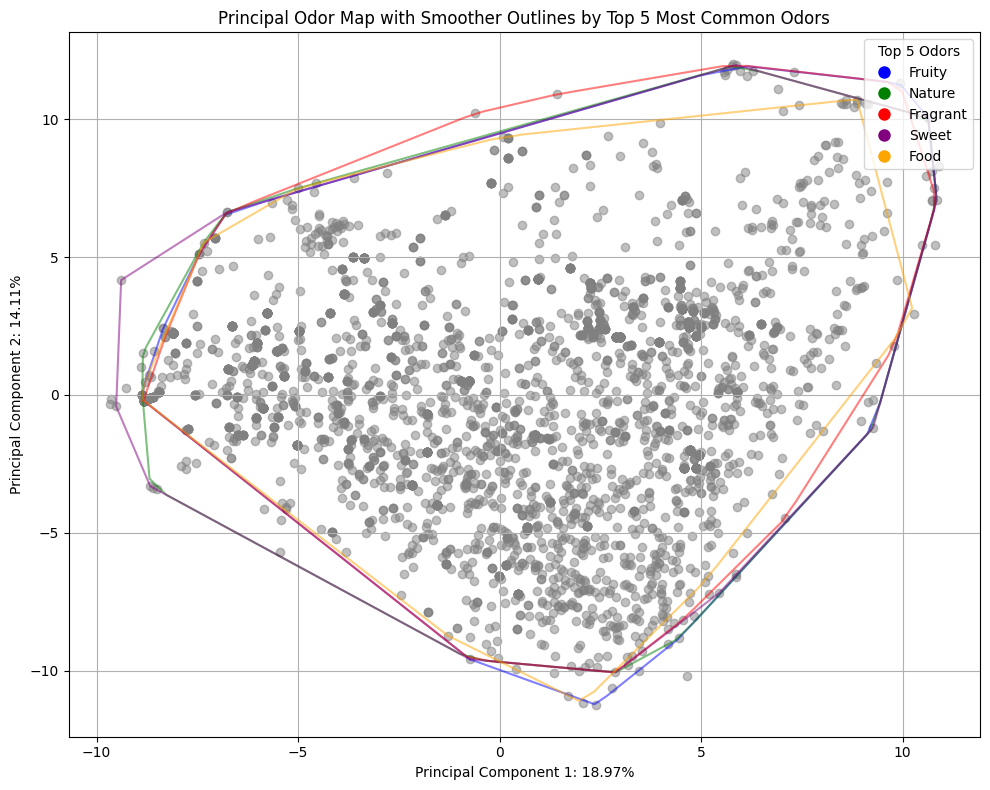

In [ ]:
# Define colors for plotting outlines
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot PCA results with gray points and smoother outlines for each top odor
plt.figure(figsize=(10, 8))

# Plot gray points
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.5, label='Other Odors')

# Plot smoother outlines for each top odor
for i, (odor, X_label) in enumerate(odor_groups.items()):
    # Calculate convex hull for the group
    hull = ConvexHull(X_label)

    # Extract points from convex hull
    points = X_label[hull.vertices]

    # Duplicate the last point to close the outline
    points = np.vstack([points, points[0]])

    # Interpolate between points for smoother outline
    t = np.arange(points.shape[0])
    interp = np.linspace(0, t.max(), 100)
    x_vals = np.interp(interp, t, points[:, 0])
    y_vals = np.interp(interp, t, points[:, 1])

    # Plot the interpolated outline
    plt.plot(x_vals, y_vals, color=colors[i], alpha=0.5, label=odor)

# Create legend for top 5 odors
legend_handles = []
for i, odor in enumerate(top_odors):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=odor))

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend
plt.legend(handles=legend_handles, title='Top 5 Odors', loc='upper right')

plt.title('Principal Odor Map with Smoother Outlines by Top 5 Most Common Odors')
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='PC1', ylabel='PC2'>

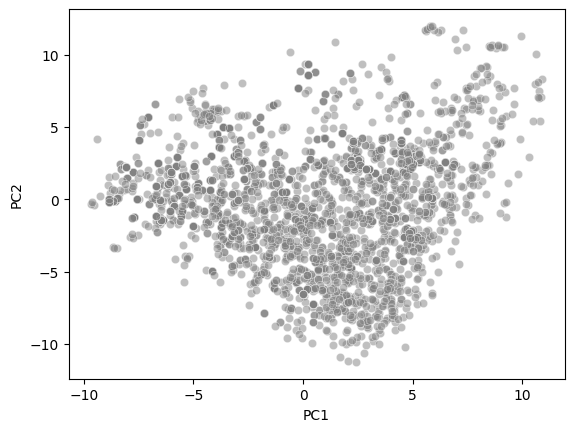

In [ ]:
sns.scatterplot(x=scaffold_df['PC1'], y=scaffold_df['PC2'], color='gray', alpha=0.5)

##Top5 menos comuns

In [ ]:
X = np.array(scaffold_df['embedding'].tolist())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Determine top 5 most common odors
top_n = 5
odor_counts = scaffold_df[odor_columns].apply(pd.Series.value_counts).sum(axis=1)

# Initialize a list to store the valid least common odors
valid_least_common_odors = []

# Iterate over the least common odors and check if they have at least 3 occurrences
for odor in odor_counts.nsmallest(len(odor_counts)).index:
    label_indices = scaffold_df['combined_odors'].str.contains(odor)
    if label_indices.sum() >= 4:
        valid_least_common_odors.append(odor)
    if len(valid_least_common_odors) == top_n:
        break

# Initialize a dictionary to store the PCA data for each of the least common odors
odor_groups = {}

# Extract the PCA data for the valid least common odors
for odor in valid_least_common_odors:
    label_indices = scaffold_df['combined_odors'].str.contains(odor)
    X_label = X_pca[label_indices]
    odor_groups[odor] = X_label

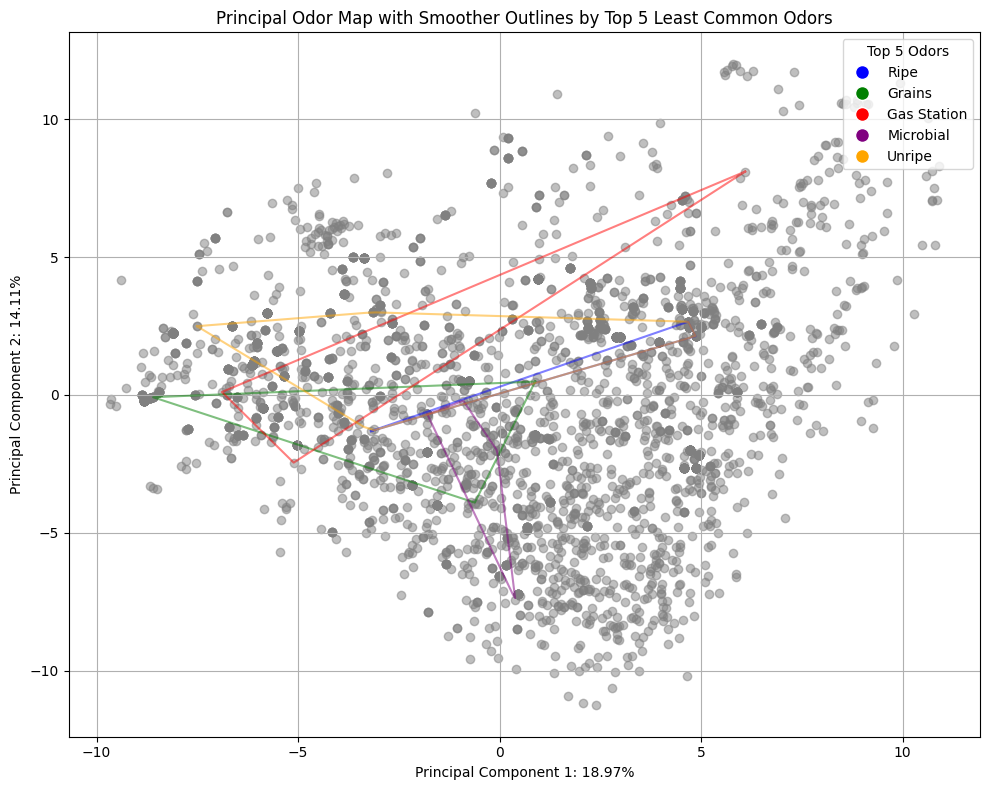

In [ ]:
# Define colors for plotting outlines
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot PCA results with gray points and smoother outlines for each top odor
plt.figure(figsize=(10, 8))

# Plot gray points
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.5, label='Other Odors')

# Plot smoother outlines for each top odor
for i, (odor, X_label) in enumerate(odor_groups.items()):
    # Calculate convex hull for the group
    hull = ConvexHull(X_label)

    # Extract points from convex hull
    points = X_label[hull.vertices]

    # Duplicate the last point to close the outline
    points = np.vstack([points, points[0]])

    # Interpolate between points for smoother outline
    t = np.arange(points.shape[0])
    interp = np.linspace(0, t.max(), 100)
    x_vals = np.interp(interp, t, points[:, 0])
    y_vals = np.interp(interp, t, points[:, 1])

    # Plot the interpolated outline
    plt.plot(x_vals, y_vals, color=colors[i], alpha=0.5, label=odor)

# Create legend for top 5 odors
legend_handles = []
for i, odor in enumerate(valid_least_common_odors):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=odor))

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend
plt.legend(handles=legend_handles, title='Top 5 Odors', loc='upper right')

plt.title('Principal Odor Map with Smoother Outlines by Top 5 Least Common Odors')
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.grid(True)
plt.tight_layout()
plt.show()

##Scatter plot

In [ ]:
scaffold_df['num_odors'] = scaffold_df[['odor_2', 'odor_3', 'odor_4', 'odor_5', 'odor_6']].notna().sum(axis=1)

In [ ]:
scaffold_df['Odors'] = scaffold_df['combined_odors'].apply(lambda x: x.split() if isinstance(x, str) else [])

In [ ]:
scaffold_df

scaffold      odor_2      odor_3      odor_4  \
0               BrC=Cc1ccccc1    Fragrant  Vegetation       Green   
1          [7*]=CCCC(C)(O)C#C         Dry   Ambrosial       Woody   
2          [15*]C1(C#C)CCCCC1         Dry  Vegetation    Aromatic   
3     [15*]C1CCCCC1([15*])C#C         Dry  Vegetation       Woody   
4                       C#CCO    Fragrant      Floral      Nature   
...                       ...         ...         ...         ...   
3419      [14*]c1cc([16*])co1      Fruity      Nature       Sweet   
3420             [14*]c1ccco1  Vegetables        Fuel  Restaurant   
3421             [14*]c1cccs1      Septic      Earthy      Marshy   
3422                  c1cscn1       Fishy      Rancid        Food   
3423    c1nc2c(o1)CCCCCCCCCC2      Earthy     Pungent  Vegetation   

             odor_5    odor_6                               combined_odors  \
0            Fruity       NaN             Fragrant Vegetation Green Fruity   
1              Waxy  Resinous            Dry Ambrosial Woody Waxy Resinous   
2             Woody     Nutty          Dry Vegetation Aromatic Woody Nutty   
3     Soft oriental  Resinous  Dry Vegetation Woody Soft oriental Resinous   
4               NaN       NaN                       Fragrant Floral Nature   
...             ...       ...                                          ...   
3419       Fragrant    Floral          Fruity Nature Sweet Fragrant Floral   
3420     Hydrocarbo       Mol    Vegetables Fuel Restaurant Hydrocarbo Mol   
3421        Pungent      Fuel            Septic Earthy Marshy Pungent Fuel   
3422        Pungent   Ammonia            Fishy Rancid Food Pungent Ammonia   
3423         Fruity  Aromatic    Earthy Pungent Vegetation Fruity Aromatic   

                                              embedding       PC1       PC2  \
0     [0.94343853, 1.4042315, 0.9404707, -1.167098, ... -3.942036 -1.013514   
1     [0.9977981, 0.014338899, 0.42459506, -0.323427...  2.054811 -1.653103   
2     [0.7932876, -0.09528034, 0.4432401, -1.1339725... -0.228414 -2.187288   
3     [0.6503303, -0.20168808, 0.3685894, -0.2083596... -1.075097 -2.556109   
4     [0.2908605, 1.1382486, 0.30650482, -1.5861013,... -4.044815  5.960289   
...                                                 ...       ...       ...   
3419  [0.7682092, -0.029936679, 0.0091098, -0.359950... -4.772369  0.281802   
3420  [0.75284666, 0.8846788, 0.28513873, -1.0306803... -8.835345 -0.201235   
3421  [0.6700586, 0.93648547, 0.23904066, -1.0179603... -8.863005  0.000405   
3422  [0.60651284, 0.98968434, -0.045383286, -1.0209... -7.430109  1.859145   
3423  [0.652708, 0.56381935, 0.5986642, -0.77238894,... -2.591823 -4.471879   

      num_odors                                              Odors  
0             4              [Fragrant, Vegetation, Green, Fruity]  
1             5            [Dry, Ambrosial, Woody, Waxy, Resinous]  
2             5          [Dry, Vegetation, Aromatic, Woody, Nutty]  
3             5  [Dry, Vegetation, Woody, Soft, oriental, Resin...  
4             3                         [Fragrant, Floral, Nature]  
...         ...                                                ...  
3419          5          [Fruity, Nature, Sweet, Fragrant, Floral]  
3420          5    [Vegetables, Fuel, Restaurant, Hydrocarbo, Mol]  
3421          5            [Septic, Earthy, Marshy, Pungent, Fuel]  
3422          5            [Fishy, Rancid, Food, Pungent, Ammonia]  
3423          5    [Earthy, Pungent, Vegetation, Fruity, Aromatic]  

[3424 rows x 12 columns]

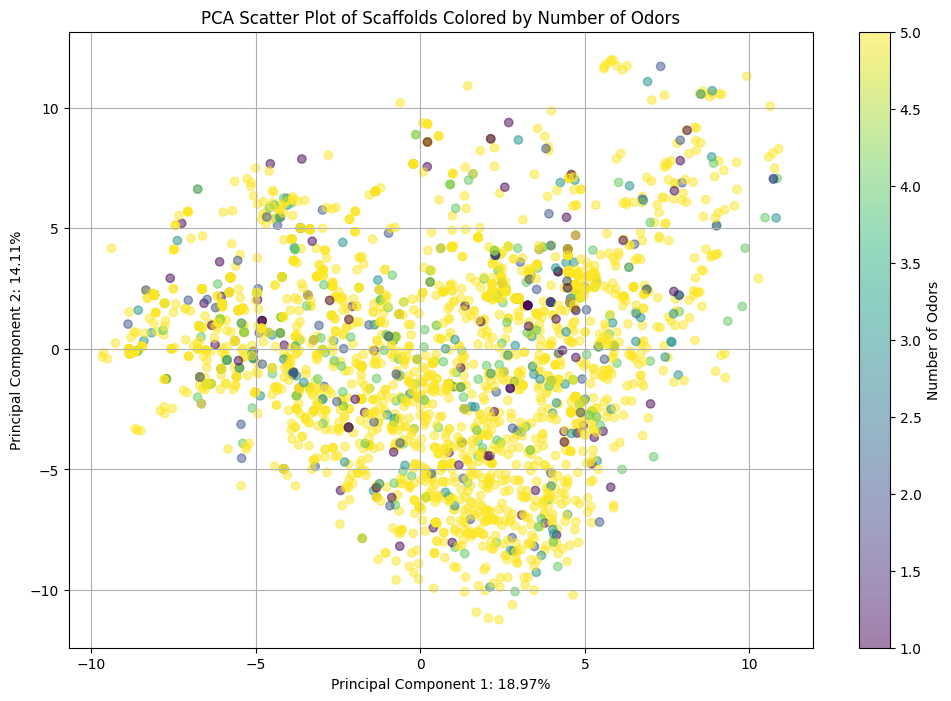

In [ ]:
plt.figure(figsize=(12, 8))
scatter = plt.scatter(scaffold_df['PC1'], scaffold_df['PC2'], c=scaffold_df['num_odors'], cmap='viridis', alpha=0.5)
plt.colorbar(scatter, label='Number of Odors')
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.title('PCA Scatter Plot of Scaffolds Colored by Number of Odors')
plt.grid(True)
plt.show()

##Histograma

<ipython-input-33-89c933cdb377>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Odor', data=odor_counts_df_sorted, palette='viridis')


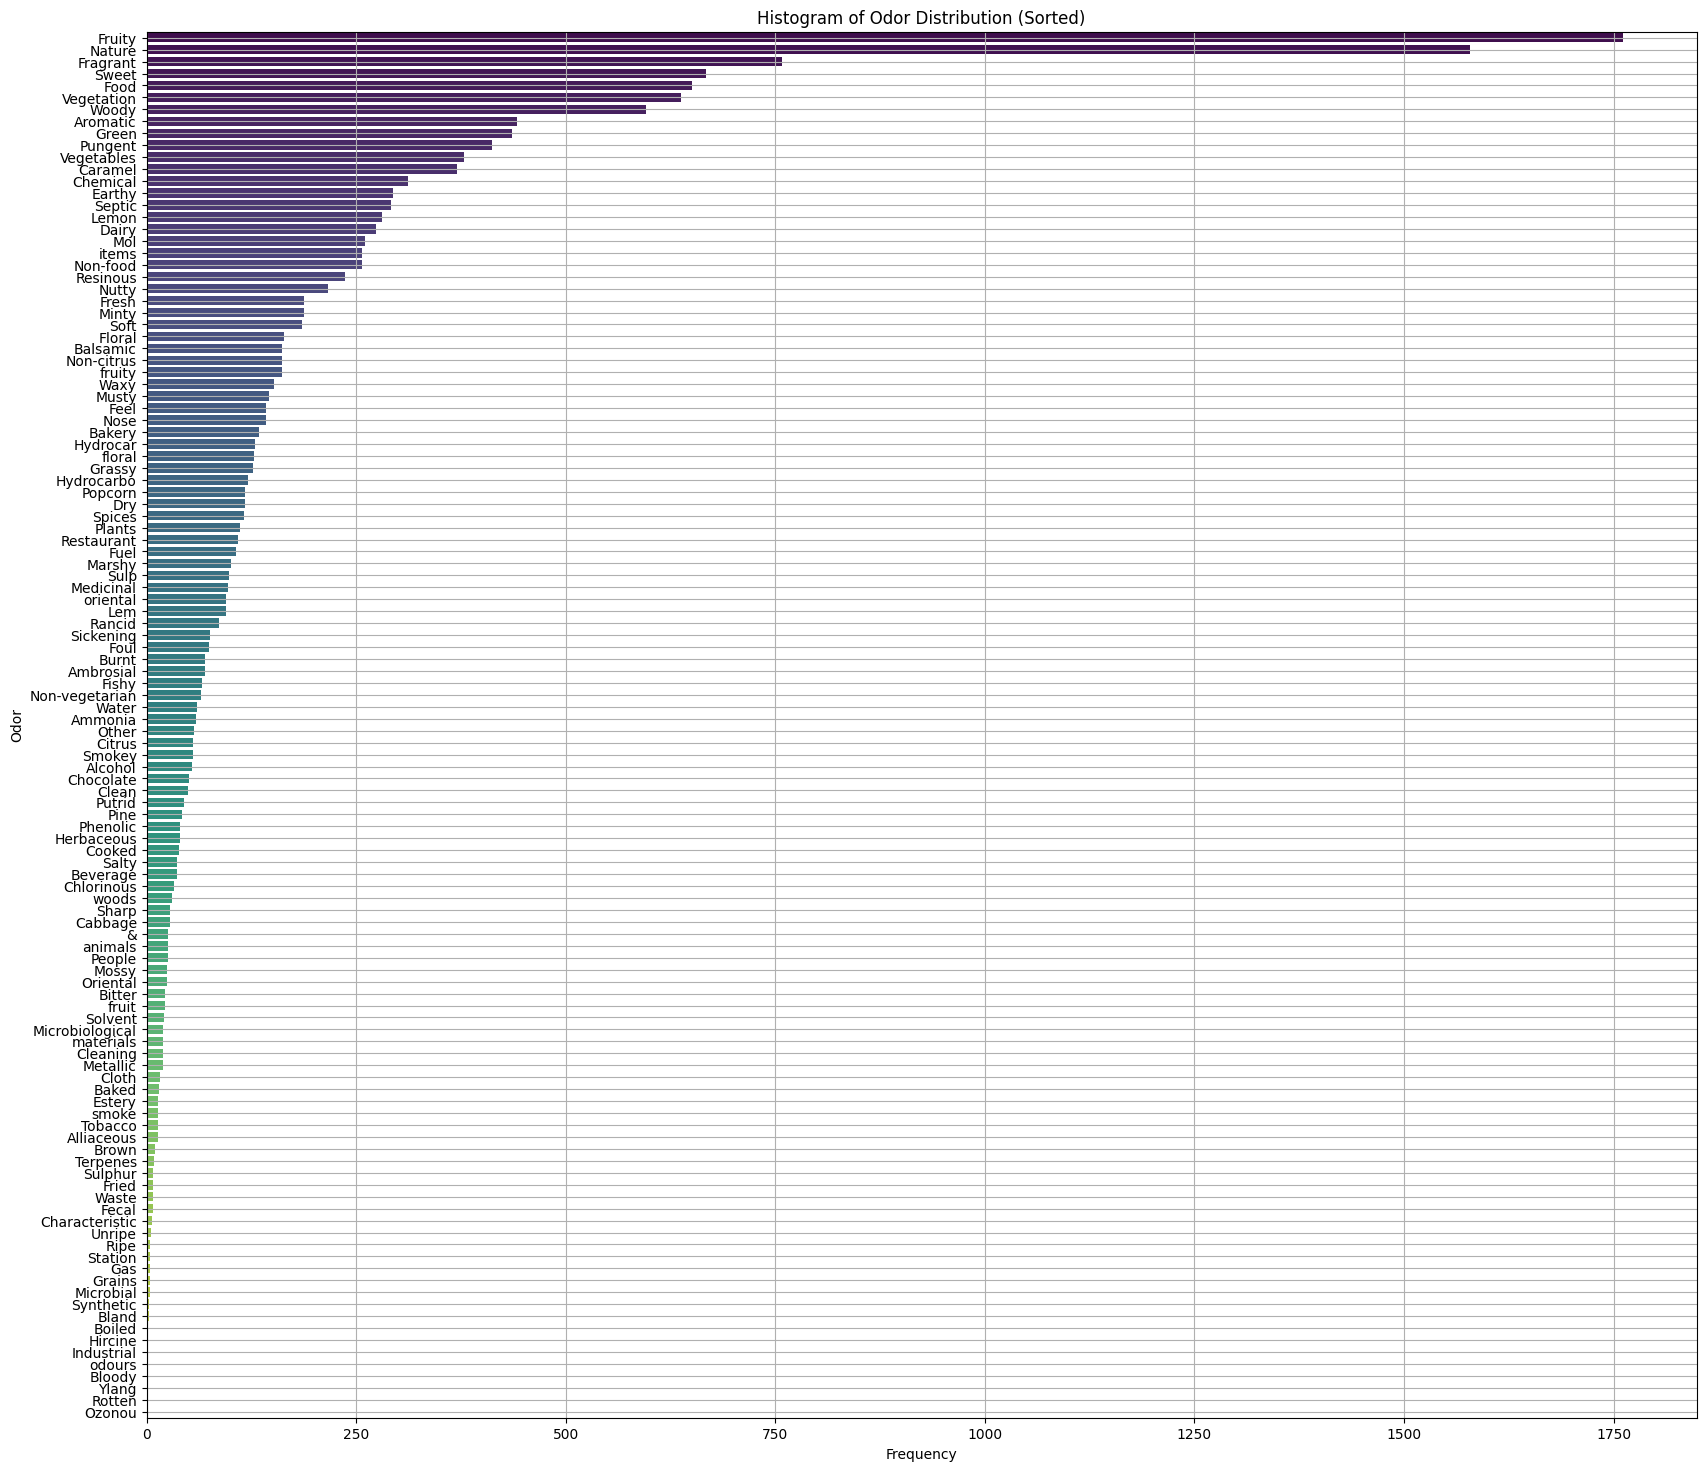

In [ ]:
from collections import Counter
all_odors = [odor for sublist in scaffold_df['Odors'] for odor in sublist]

# Count the frequency of each odor
odor_counts = Counter(all_odors)

# Create a DataFrame for the odor counts
odor_counts_df = pd.DataFrame.from_dict(odor_counts, orient='index', columns=['Count']).reset_index()
odor_counts_df.rename(columns={'index': 'Odor'}, inplace=True)
# Sort the odor counts dataframe by frequency in descending order
odor_counts_df_sorted = odor_counts_df.sort_values(by='Count', ascending=False)

# Plot histogram of odor distribution with sorted data
plt.figure(figsize=(20, 18))
sns.barplot(x='Count', y='Odor', data=odor_counts_df_sorted, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Odor')
plt.title('Histogram of Odor Distribution (Sorted)')
plt.grid(True)
plt.show()

#Odores

In [ ]:
import pandas as pd

In [ ]:
df_0 = pd.read_csv("/content/olfactionbase_odors_odorant_data_with_smiles.csv")

In [ ]:
len(df_0['Primary Odor'].value_counts())

106

In [ ]:
df_0

Sr. No     Primary Odor    Sub-odor               CAS-Id  \
0           1       Alliaceous  Alliaceous              74-93-1   
1           2       Alliaceous  Alliaceous                 4618   
2           3       Alliaceous  Alliaceous              75-33-2   
3           4       Alliaceous  Alliaceous             100-53-8   
4           5       Alliaceous  Alliaceous             107-03-9   
...       ...              ...         ...                  ...   
43340   43341  Woody/ Resinous       Woody            1323-75-7   
43341   43342  Woody/ Resinous       Woody           94248-21-2   
43342   43343            Ylang     Yoghurt  2096-04-08 00:00:00   
43343   43344            Ylang     Yoghurt             616-09-1   
43344   43345            Zesty       Zesty           41816-03-9   

                                           Chemical name  \
0                                           Methanethiol   
1                                            Ethanethiol   
2                                         2-Propanethiol   
3                                       Benzyl mercaptan   
4                                         1-Propanethiol   
...                                                  ...   
43340                             Santalyl phenylacetate   
43341  (1S,7S)-5,9-Dimethyltricyclo[5.2.1.02,6]dec-4-...   
43342                                   2,3-Heptanedione   
43343                                     Propyl lactate   
43344  Spiro(1,4-methanonaphthalene-2(1H),2'-oxirane)...   

                                              SMILES  
0                                                 CS  
1                                                CCS  
2                                             CC(C)S  
3                                    C1=CC=C(C=C1)CS  
4                                               CCCS  
...                                              ...  
43340  CC(=CCCC1(C2CCC(C2)C1=C)C)COC(=O)CC3=CC=CC=C3  
43341                                            NaN  
43342                                CCCCC(=O)C(=O)C  
43343                                 CCCOC(=O)C(C)O  
43344                                            NaN  

[43345 rows x 6 columns]

In [ ]:
df = df_0.dropna()

In [ ]:
df

Sr. No     Primary Odor    Sub-odor               CAS-Id  \
0           1       Alliaceous  Alliaceous              74-93-1   
1           2       Alliaceous  Alliaceous                 4618   
2           3       Alliaceous  Alliaceous              75-33-2   
3           4       Alliaceous  Alliaceous             100-53-8   
4           5       Alliaceous  Alliaceous             107-03-9   
...       ...              ...         ...                  ...   
43335   43336  Woody/ Resinous       Woody           32669-00-4   
43339   43340  Woody/ Resinous       Woody          476332-65-7   
43340   43341  Woody/ Resinous       Woody            1323-75-7   
43342   43343            Ylang     Yoghurt  2096-04-08 00:00:00   
43343   43344            Ylang     Yoghurt             616-09-1   

                                           Chemical name  \
0                                           Methanethiol   
1                                            Ethanethiol   
2                                         2-Propanethiol   
3                                       Benzyl mercaptan   
4                                         1-Propanethiol   
...                                                  ...   
43335                   Ethanone, 1-(3-cycloocten-1-yl)-   
43339  Decahydro-2,2,6,6,7,8,8-heptamethyl-2H-indeno(...   
43340                             Santalyl phenylacetate   
43342                                   2,3-Heptanedione   
43343                                     Propyl lactate   

                                              SMILES  
0                                                 CS  
1                                                CCS  
2                                             CC(C)S  
3                                    C1=CC=C(C=C1)CS  
4                                               CCCS  
...                                              ...  
43335                              CC(=O)C1CCCCC=CC1  
43339            CC1C(C2CCC3CC(OC3C2C1(C)C)(C)C)(C)C  
43340  CC(=CCCC1(C2CCC(C2)C1=C)C)COC(=O)CC3=CC=CC=C3  
43342                                CCCCC(=O)C(=O)C  
43343                                 CCCOC(=O)C(C)O  

[41824 rows x 6 columns]

In [ ]:
num_primary_odors = df['Primary Odor'].nunique()
num_primary_odors

104

In [ ]:
df['Primary Odor'].unique().tolist()

['Alliaceous',
 'Ambrosial',
 'Ammonia',
 'Aromatic',
 'Baked',
 'Bakery',
 'Balsamic',
 'Bitter',
 'Bland',
 'Bloody',
 'Boiled',
 'Beverage',
 'Brown',
 'Building materials &',
 'Burnt',
 'Caramel',
 'Characteristic',
 'Chemical/ Hydrocar',
 'Chlorinous',
 'Chlorinous/ Ozonou',
 'Chocolate',
 'Citrus',
 'Clean',
 'Cleaning materials',
 'Cloth',
 'Coal tar',
 'Cooked',
 'Dairy',
 'Dry',
 'Dry fruit',
 'Dry woods',
 'Earthy',
 'Earthy/ Musty/ Mol',
 'Estery',
 'Fecal/ Sewery',
 'Fishy/ Ammonia',
 'Fishy/ Rancid',
 'Floral',
 'Food',
 'Foul',
 'Fragrant',
 'Fragrant/ Fruity',
 'Fresh',
 'Fried',
 'Fruity',
 'Fuel/ Gas Station/ S',
 'Grains',
 'Grassy/ Woody',
 'Green',
 'Herbaceous',
 'Hircine',
 'Industrial odours',
 'Lemon',
 'Marshy/ Septic/ Sulp',
 'Medicinal/ Alcohol',
 'Medicinal/ Phenolic',
 'Metallic',
 'Microbial',
 'Microbiological',
 'Minty',
 'Mossy woods',
 'Nature',
 'Nauseating',
 'Non-citrus fruity',
 'Non-food items',
 'Non-vegetarian',
 'Nose Feel',
 'Nutty',
 'Orienta

In [ ]:
sub_odors_per_primary = df.groupby('Primary Odor')['Sub-odor'].nunique().reset_index(name='Number of Sub-Odors')
sub_odors_per_primary

Primary Odor  Number of Sub-Odors
0         Alliaceous                    3
1          Ambrosial                    1
2            Ammonia                    2
3           Aromatic                    4
4              Baked                    2
..               ...                  ...
99              Waxy                    1
100            Woody                   10
101   Woody oriental                    2
102  Woody/ Resinous                   13
103            Ylang                    1

[104 rows x 2 columns]

In [ ]:
sub_odor_counts = df.groupby(['Primary Odor', 'Sub-odor']).size().reset_index(name='count')

# Sort counts in descending order and pick the top 3 for each "Primary Odor"
top_sub_odors = sub_odor_counts.sort_values(['Primary Odor', 'count'], ascending=[True, False])
top_3_sub_odors = top_sub_odors.groupby('Primary Odor').head(3).reset_index(drop=True)


In [ ]:
top_3_sub_odors

Primary Odor    Sub-odor  count
0         Alliaceous       Onion    119
1         Alliaceous      Garlic     81
2         Alliaceous  Alliaceous     77
3          Ambrosial        Musk     74
4            Ammonia       Fishy     61
..               ...         ...    ...
249   Woody oriental   Patchouli     18
250  Woody/ Resinous       Woody    571
251  Woody/ Resinous      Herbal    563
252  Woody/ Resinous      Earthy    267
253            Ylang     Yoghurt      2

[254 rows x 3 columns]

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Grassy/ Woody']

Primary Odor              Sub-odor  count
112  Grassy/ Woody                 Woody    571
113  Grassy/ Woody  Grassy(Green, Sharp)     68
114  Grassy/ Woody                Grassy     55

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Water']

Primary Odor Sub-odor  count
241        Water    Water     34
242        Water    Ozone     31
243        Water   Marine     29

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Dairy']

Primary Odor Sub-odor  count
56        Dairy   Creamy    175
57        Dairy  Buttery    118
58        Dairy   Cheese    118

In [ ]:
selected_odors = ['Grassy/ Woody', 'Water', 'Dairy']
subsample_df = df[df['Primary Odor'].isin(selected_odors)].reset_index(drop=True)

In [ ]:
selected_subodors = ['Woody', 'Grassy(Green, Sharp)', 'Grassy', 'Water', 'Ozone', 'Marine', 'Creamy', 'Buttery', 'Cheese']
subsample_df = subsample_df[subsample_df['Sub-odor'].isin(selected_subodors)].reset_index(drop=True)

In [ ]:
subsample_df

Sr. No Primary Odor Sub-odor       CAS-Id  \
0       5489        Dairy  Buttery     513-86-0   
1       5490        Dairy  Buttery     513-85-9   
2       5491        Dairy  Buttery     107-92-6   
3       5492        Dairy  Buttery     431-03-8   
4       5493        Dairy  Buttery      67-68-5   
...      ...          ...      ...          ...   
1194   40015        Water    Water  196109-18-9   
1195   40016        Water    Water  851768-51-9   
1196   40017        Water    Water   85351-07-1   
1197   40019        Water    Water   68133-72-2   
1198   40020        Water    Water   56805-23-3   

                         Chemical name             SMILES  
0                              Acetoin        CC(C(=O)C)O  
1                       2,3-Butanediol         CC(C(C)O)O  
2                         Butyric acid          CCCC(=O)O  
3                      2,3-Butanedione       CC(=O)C(=O)C  
4                   Dimethyl sulfoxide            CS(=O)C  
...                                ...                ...  
1194              5-Octenyl propanoate  CCC=CCCCCOC(=O)CC  
1195  3-Hexanone, 5-mercapto-5-methyl-   CCC(=O)CC(C)(C)S  
1196           3-Methyldodecanonitrile  CCCCCCCCCC(C)CC#N  
1197    cis-3-Hexenyl oxy-acetaldehyde       CCC=CCCOCC=O  
1198         (3E,6Z)-3,6-Nonadien-1-ol       CCC=CCC=CCCO  

[1199 rows x 6 columns]

##Passando para embeddings e usando pca

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import BRICS
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
import torch
import seaborn as sns

In [ ]:
mixed_df = subsample_df[subsample_df['SMILES'].str.contains(r'\.')]

In [ ]:
mixed_df

Sr. No Primary Odor Sub-odor      CAS-Id                  Chemical name  \
92     5582        Dairy  Buttery   4502-00-5  Sodium 4-methyl-2-oxovalerate   
232    5725        Dairy   Cheese  10255-67-1        Sodium mercaptopyruvate   

                         SMILES  
92   CC(C)CC(=O)C(=O)[O-].[Na+]  
232    C(C(=O)C(=O)[O-])S.[Na+]

In [ ]:
subsample_df = subsample_df[~subsample_df['SMILES'].str.contains(r'\.')].reset_index(drop=True)

In [ ]:
subsample_df

Sr. No Primary Odor Sub-odor       CAS-Id  \
0       5489        Dairy  Buttery     513-86-0   
1       5490        Dairy  Buttery     513-85-9   
2       5491        Dairy  Buttery     107-92-6   
3       5492        Dairy  Buttery     431-03-8   
4       5493        Dairy  Buttery      67-68-5   
...      ...          ...      ...          ...   
1192   40015        Water    Water  196109-18-9   
1193   40016        Water    Water  851768-51-9   
1194   40017        Water    Water   85351-07-1   
1195   40019        Water    Water   68133-72-2   
1196   40020        Water    Water   56805-23-3   

                         Chemical name             SMILES  
0                              Acetoin        CC(C(=O)C)O  
1                       2,3-Butanediol         CC(C(C)O)O  
2                         Butyric acid          CCCC(=O)O  
3                      2,3-Butanedione       CC(=O)C(=O)C  
4                   Dimethyl sulfoxide            CS(=O)C  
...                                ...                ...  
1192              5-Octenyl propanoate  CCC=CCCCCOC(=O)CC  
1193  3-Hexanone, 5-mercapto-5-methyl-   CCC(=O)CC(C)(C)S  
1194           3-Methyldodecanonitrile  CCCCCCCCCC(C)CC#N  
1195    cis-3-Hexenyl oxy-acetaldehyde       CCC=CCCOCC=O  
1196         (3E,6Z)-3,6-Nonadien-1-ol       CCC=CCC=CCCO  

[1197 rows x 6 columns]

In [ ]:
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # Standardize the molecule
    normalizer = rdMolStandardize.Normalizer()
    mol = normalizer.normalize(mol)
    return Chem.MolToSmiles(mol)

In [ ]:
subsample_df['standardized_smiles'] = subsample_df['SMILES'].apply(standardize_smiles)

[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Rule applied: Sulfoxide to -S+(O-)-
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:14] Running Normalizer
[13:06:14] Initializing Normalizer
[13:06:1

In [ ]:
subsample_df

Sr. No Primary Odor Sub-odor       CAS-Id  \
0       5489        Dairy  Buttery     513-86-0   
1       5490        Dairy  Buttery     513-85-9   
2       5491        Dairy  Buttery     107-92-6   
3       5492        Dairy  Buttery     431-03-8   
4       5493        Dairy  Buttery      67-68-5   
...      ...          ...      ...          ...   
1192   40015        Water    Water  196109-18-9   
1193   40016        Water    Water  851768-51-9   
1194   40017        Water    Water   85351-07-1   
1195   40019        Water    Water   68133-72-2   
1196   40020        Water    Water   56805-23-3   

                         Chemical name             SMILES standardized_smiles  
0                              Acetoin        CC(C(=O)C)O         CC(=O)C(C)O  
1                       2,3-Butanediol         CC(C(C)O)O          CC(O)C(C)O  
2                         Butyric acid          CCCC(=O)O           CCCC(=O)O  
3                      2,3-Butanedione       CC(=O)C(=O)C        CC(=O)C(C)=O  
4                   Dimethyl sulfoxide            CS(=O)C        C[S+](C)[O-]  
...                                ...                ...                 ...  
1192              5-Octenyl propanoate  CCC=CCCCCOC(=O)CC   CCC=CCCCCOC(=O)CC  
1193  3-Hexanone, 5-mercapto-5-methyl-   CCC(=O)CC(C)(C)S    CCC(=O)CC(C)(C)S  
1194           3-Methyldodecanonitrile  CCCCCCCCCC(C)CC#N   CCCCCCCCCC(C)CC#N  
1195    cis-3-Hexenyl oxy-acetaldehyde       CCC=CCCOCC=O        CCC=CCCOCC=O  
1196         (3E,6Z)-3,6-Nonadien-1-ol       CCC=CCC=CCCO        CCC=CCC=CCCO  

[1197 rows x 7 columns]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to generate ChemBERTa embeddings from SMILES
def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings as the molecular embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

In [ ]:
subsample_df['embedding'] = subsample_df['standardized_smiles'].apply(smiles_to_embedding)

In [ ]:
X = np.array(subsample_df['embedding'].tolist())
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
subsample_df['PCA1'] = X_pca[:, 0]
subsample_df['PCA2'] = X_pca[:, 1]

In [ ]:
subsample_df

Sr. No Primary Odor Sub-odor       CAS-Id  \
0       5489        Dairy  Buttery     513-86-0   
1       5490        Dairy  Buttery     513-85-9   
2       5491        Dairy  Buttery     107-92-6   
3       5492        Dairy  Buttery     431-03-8   
4       5493        Dairy  Buttery      67-68-5   
...      ...          ...      ...          ...   
1192   40015        Water    Water  196109-18-9   
1193   40016        Water    Water  851768-51-9   
1194   40017        Water    Water   85351-07-1   
1195   40019        Water    Water   68133-72-2   
1196   40020        Water    Water   56805-23-3   

                         Chemical name             SMILES standardized_smiles  \
0                              Acetoin        CC(C(=O)C)O         CC(=O)C(C)O   
1                       2,3-Butanediol         CC(C(C)O)O          CC(O)C(C)O   
2                         Butyric acid          CCCC(=O)O           CCCC(=O)O   
3                      2,3-Butanedione       CC(=O)C(=O)C        CC(=O)C(C)=O   
4                   Dimethyl sulfoxide            CS(=O)C        C[S+](C)[O-]   
...                                ...                ...                 ...   
1192              5-Octenyl propanoate  CCC=CCCCCOC(=O)CC   CCC=CCCCCOC(=O)CC   
1193  3-Hexanone, 5-mercapto-5-methyl-   CCC(=O)CC(C)(C)S    CCC(=O)CC(C)(C)S   
1194           3-Methyldodecanonitrile  CCCCCCCCCC(C)CC#N   CCCCCCCCCC(C)CC#N   
1195    cis-3-Hexenyl oxy-acetaldehyde       CCC=CCCOCC=O        CCC=CCCOCC=O   
1196         (3E,6Z)-3,6-Nonadien-1-ol       CCC=CCC=CCCO        CCC=CCC=CCCO   

                                              embedding       PCA1      PCA2  
0     [0.6649713, 0.13681996, -0.2733331, -0.4285883...   4.214975 -2.727164  
1     [0.9872167, 0.44504884, 0.32016712, -0.4863462...  -2.242676 -0.505452  
2     [0.3280301, 0.51357615, -0.63585323, -1.445083...  14.289735  0.553192  
3     [0.49654242, -0.007300198, -0.49999145, -0.806...   7.533947 -2.655295  
4     [1.3555996, 0.7328784, -0.33750913, -0.5625933...   0.863181  3.769117  
...                                                 ...        ...       ...  
1192  [0.23060901, 0.3355071, -0.3226602, -1.3424346...  11.771789 -0.665756  
1193  [0.7859412, 0.46736842, 0.05359179, -0.9550642...   0.203098 -0.546818  
1194  [1.1074185, 0.56591976, 0.71013534, -1.2262491...  -3.479513  3.070411  
1195  [-0.1019277, 0.10848767, -0.6912953, -0.968693...  11.118203 -2.937155  
1196  [0.7442918, 0.5487854, -0.21071026, -0.7935706...   7.706204 -4.678247  

[1197 rows x 10 columns]

<Axes: xlabel='PCA1', ylabel='PCA2'>

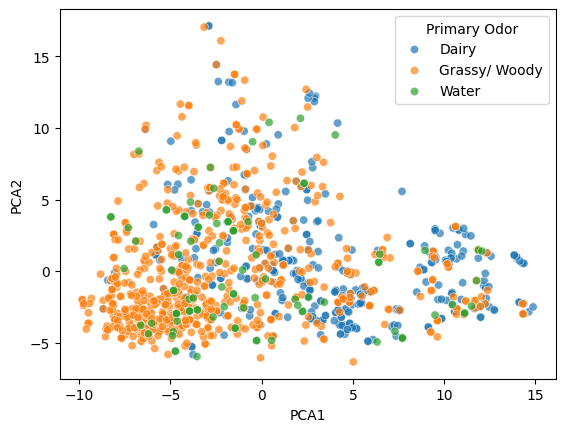

In [ ]:
sns.scatterplot(data=subsample_df, x='PCA1', y='PCA2', hue='Primary Odor', palette='tab10', alpha=0.7)

<Axes: xlabel='PCA1', ylabel='PCA2'>

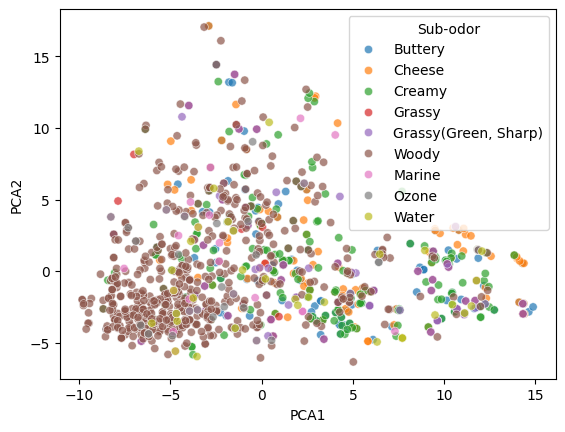

In [ ]:
sns.scatterplot(data=subsample_df, x='PCA1', y='PCA2', hue='Sub-odor', palette='tab10', alpha=0.7)

<ipython-input-98-f534e02fc668>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(primary_odors))


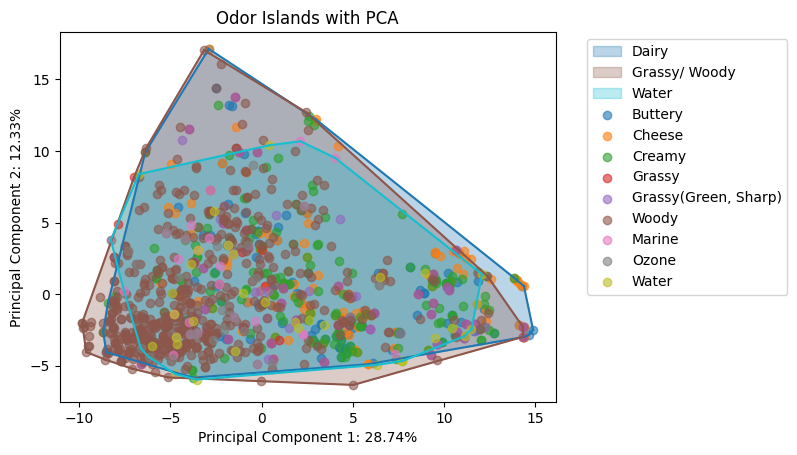

In [ ]:
def plot_convex_hull(points, label, color):
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=color)
    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.3, label=label)

# Get unique primary odors and assign colors
primary_odors = subsample_df['Primary Odor'].unique()
colors = plt.cm.get_cmap('tab10', len(primary_odors))

for i, primary_odor in enumerate(primary_odors):
    subset = subsample_df[subsample_df['Primary Odor'] == primary_odor]
    points = subset[['PCA1', 'PCA2']].values
    plot_convex_hull(points, primary_odor, colors(i))

# Scatter plot for sub-odors
for sub_odor in subsample_df['Sub-odor'].unique():
    subset = subsample_df[subsample_df['Sub-odor'] == sub_odor]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=sub_odor, alpha=0.6)

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend and labels
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.title('Odor Islands with PCA')
plt.show()

#Testes com clusterização

In [ ]:
import pandas as pd

In [ ]:
df_0 = pd.read_csv("/content/olfactionbase_odors_odorant_data_with_smiles.csv")

In [ ]:
len(df_0['Primary Odor'].value_counts())

106

In [ ]:
df_0

Sr. No     Primary Odor    Sub-odor               CAS-Id  \
0           1       Alliaceous  Alliaceous              74-93-1   
1           2       Alliaceous  Alliaceous                 4618   
2           3       Alliaceous  Alliaceous              75-33-2   
3           4       Alliaceous  Alliaceous             100-53-8   
4           5       Alliaceous  Alliaceous             107-03-9   
...       ...              ...         ...                  ...   
43340   43341  Woody/ Resinous       Woody            1323-75-7   
43341   43342  Woody/ Resinous       Woody           94248-21-2   
43342   43343            Ylang     Yoghurt  2096-04-08 00:00:00   
43343   43344            Ylang     Yoghurt             616-09-1   
43344   43345            Zesty       Zesty           41816-03-9   

                                           Chemical name  \
0                                           Methanethiol   
1                                            Ethanethiol   
2                                         2-Propanethiol   
3                                       Benzyl mercaptan   
4                                         1-Propanethiol   
...                                                  ...   
43340                             Santalyl phenylacetate   
43341  (1S,7S)-5,9-Dimethyltricyclo[5.2.1.02,6]dec-4-...   
43342                                   2,3-Heptanedione   
43343                                     Propyl lactate   
43344  Spiro(1,4-methanonaphthalene-2(1H),2'-oxirane)...   

                                              SMILES  
0                                                 CS  
1                                                CCS  
2                                             CC(C)S  
3                                    C1=CC=C(C=C1)CS  
4                                               CCCS  
...                                              ...  
43340  CC(=CCCC1(C2CCC(C2)C1=C)C)COC(=O)CC3=CC=CC=C3  
43341                                            NaN  
43342                                CCCCC(=O)C(=O)C  
43343                                 CCCOC(=O)C(C)O  
43344                                            NaN  

[43345 rows x 6 columns]

In [ ]:
df = df_0.dropna()

In [ ]:
df

Sr. No     Primary Odor    Sub-odor               CAS-Id  \
0           1       Alliaceous  Alliaceous              74-93-1   
1           2       Alliaceous  Alliaceous                 4618   
2           3       Alliaceous  Alliaceous              75-33-2   
3           4       Alliaceous  Alliaceous             100-53-8   
4           5       Alliaceous  Alliaceous             107-03-9   
...       ...              ...         ...                  ...   
43335   43336  Woody/ Resinous       Woody           32669-00-4   
43339   43340  Woody/ Resinous       Woody          476332-65-7   
43340   43341  Woody/ Resinous       Woody            1323-75-7   
43342   43343            Ylang     Yoghurt  2096-04-08 00:00:00   
43343   43344            Ylang     Yoghurt             616-09-1   

                                           Chemical name  \
0                                           Methanethiol   
1                                            Ethanethiol   
2                                         2-Propanethiol   
3                                       Benzyl mercaptan   
4                                         1-Propanethiol   
...                                                  ...   
43335                   Ethanone, 1-(3-cycloocten-1-yl)-   
43339  Decahydro-2,2,6,6,7,8,8-heptamethyl-2H-indeno(...   
43340                             Santalyl phenylacetate   
43342                                   2,3-Heptanedione   
43343                                     Propyl lactate   

                                              SMILES  
0                                                 CS  
1                                                CCS  
2                                             CC(C)S  
3                                    C1=CC=C(C=C1)CS  
4                                               CCCS  
...                                              ...  
43335                              CC(=O)C1CCCCC=CC1  
43339            CC1C(C2CCC3CC(OC3C2C1(C)C)(C)C)(C)C  
43340  CC(=CCCC1(C2CCC(C2)C1=C)C)COC(=O)CC3=CC=CC=C3  
43342                                CCCCC(=O)C(=O)C  
43343                                 CCCOC(=O)C(C)O  

[41824 rows x 6 columns]

In [ ]:
num_primary_odors = df['Primary Odor'].nunique()
num_primary_odors

104

In [ ]:
df['Primary Odor'].unique().tolist()

['Alliaceous',
 'Ambrosial',
 'Ammonia',
 'Aromatic',
 'Baked',
 'Bakery',
 'Balsamic',
 'Bitter',
 'Bland',
 'Bloody',
 'Boiled',
 'Beverage',
 'Brown',
 'Building materials &',
 'Burnt',
 'Caramel',
 'Characteristic',
 'Chemical/ Hydrocar',
 'Chlorinous',
 'Chlorinous/ Ozonou',
 'Chocolate',
 'Citrus',
 'Clean',
 'Cleaning materials',
 'Cloth',
 'Coal tar',
 'Cooked',
 'Dairy',
 'Dry',
 'Dry fruit',
 'Dry woods',
 'Earthy',
 'Earthy/ Musty/ Mol',
 'Estery',
 'Fecal/ Sewery',
 'Fishy/ Ammonia',
 'Fishy/ Rancid',
 'Floral',
 'Food',
 'Foul',
 'Fragrant',
 'Fragrant/ Fruity',
 'Fresh',
 'Fried',
 'Fruity',
 'Fuel/ Gas Station/ S',
 'Grains',
 'Grassy/ Woody',
 'Green',
 'Herbaceous',
 'Hircine',
 'Industrial odours',
 'Lemon',
 'Marshy/ Septic/ Sulp',
 'Medicinal/ Alcohol',
 'Medicinal/ Phenolic',
 'Metallic',
 'Microbial',
 'Microbiological',
 'Minty',
 'Mossy woods',
 'Nature',
 'Nauseating',
 'Non-citrus fruity',
 'Non-food items',
 'Non-vegetarian',
 'Nose Feel',
 'Nutty',
 'Orienta

In [ ]:
sub_odors_per_primary = df.groupby('Primary Odor')['Sub-odor'].nunique().reset_index(name='Number of Sub-Odors')
sub_odors_per_primary

Primary Odor  Number of Sub-Odors
0         Alliaceous                    3
1          Ambrosial                    1
2            Ammonia                    2
3           Aromatic                    4
4              Baked                    2
..               ...                  ...
99              Waxy                    1
100            Woody                   10
101   Woody oriental                    2
102  Woody/ Resinous                   13
103            Ylang                    1

[104 rows x 2 columns]

In [ ]:
sub_odor_counts = df.groupby(['Primary Odor', 'Sub-odor']).size().reset_index(name='count')

# Sort counts in descending order and pick the top 3 for each "Primary Odor"
top_sub_odors = sub_odor_counts.sort_values(['Primary Odor', 'count'], ascending=[True, False])
top_3_sub_odors = top_sub_odors.groupby('Primary Odor').head(3).reset_index(drop=True)


In [ ]:
top_3_sub_odors

Primary Odor    Sub-odor  count
0         Alliaceous       Onion    119
1         Alliaceous      Garlic     81
2         Alliaceous  Alliaceous     77
3          Ambrosial        Musk     74
4            Ammonia       Fishy     61
..               ...         ...    ...
249   Woody oriental   Patchouli     18
250  Woody/ Resinous       Woody    571
251  Woody/ Resinous      Herbal    563
252  Woody/ Resinous      Earthy    267
253            Ylang     Yoghurt      2

[254 rows x 3 columns]

In [ ]:
filtered_df = top_3_sub_odors[(top_3_sub_odors['count'] >= 10) & (top_3_sub_odors['count'] <= 100)]
primary_odor_counts = filtered_df['Primary Odor'].value_counts()
result_primary_odors = primary_odor_counts[primary_odor_counts == 3].index.tolist()
result_primary_odors

['Plants',
 'Water',
 'Terpenes/ Pine/ Lem',
 'Microbiological',
 'Solvent/ Hydrocarbo',
 'Rancid/ Putrid',
 'Fuel/ Gas Station/ S',
 'Dry fruit',
 'Other']

<ipython-input-33-89c933cdb377>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Odor', data=odor_counts_df_sorted, palette='viridis')


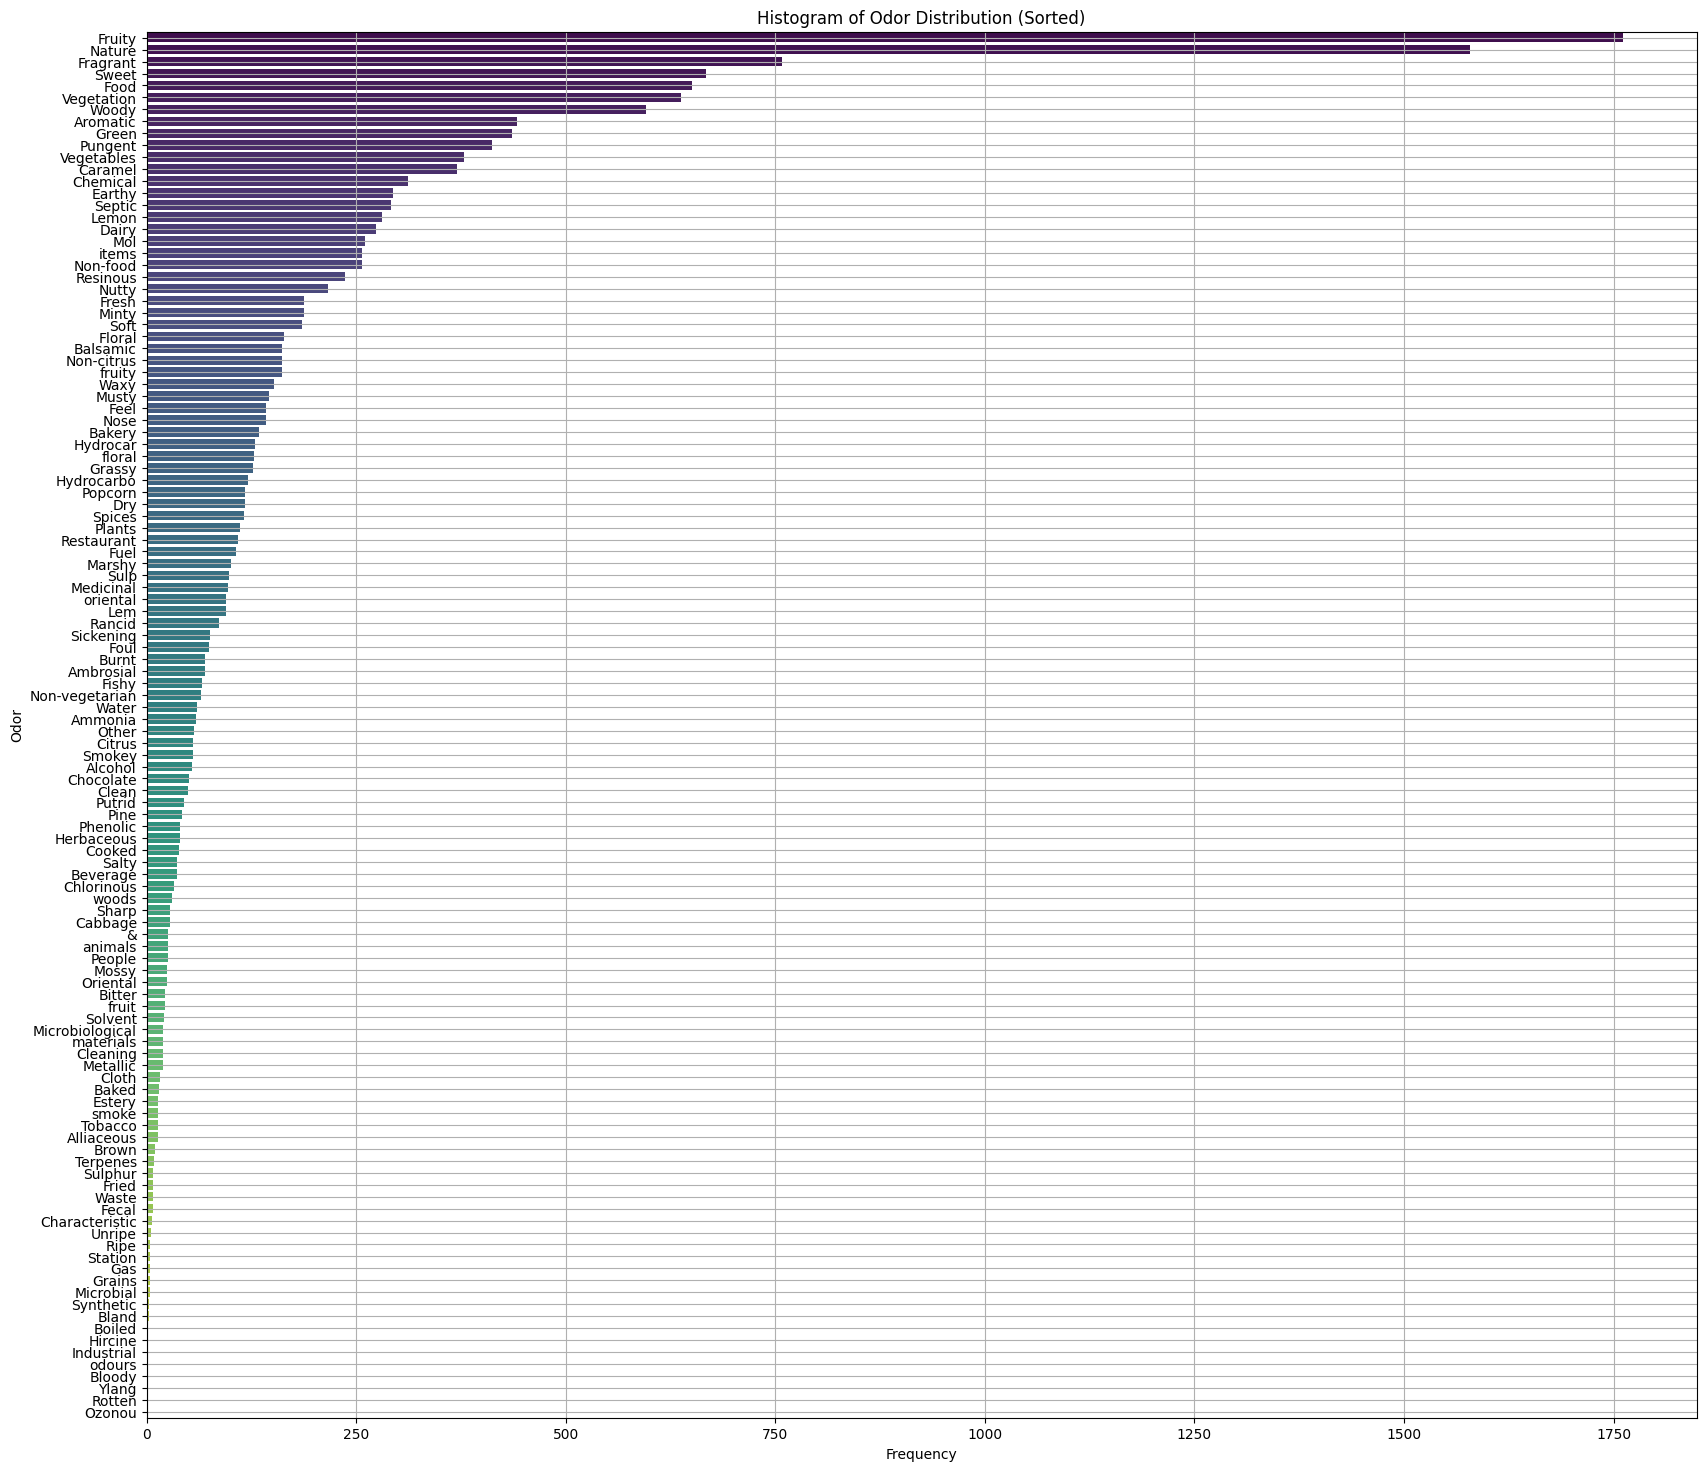

In [ ]:
from collections import Counter
all_odors = [odor for sublist in scaffold_df['Odors'] for odor in sublist]

# Count the frequency of each odor
odor_counts = Counter(all_odors)

# Create a DataFrame for the odor counts
odor_counts_df = pd.DataFrame.from_dict(odor_counts, orient='index', columns=['Count']).reset_index()
odor_counts_df.rename(columns={'index': 'Odor'}, inplace=True)
# Sort the odor counts dataframe by frequency in descending order
odor_counts_df_sorted = odor_counts_df.sort_values(by='Count', ascending=False)

# Plot histogram of odor distribution with sorted data
plt.figure(figsize=(20, 18))
sns.barplot(x='Count', y='Odor', data=odor_counts_df_sorted, palette='viridis')
plt.xlabel('Frequency')
plt.ylabel('Odor')
plt.title('Histogram of Odor Distribution (Sorted)')
plt.grid(True)
plt.show()

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Microbiological']

Primary Odor  Sub-odor  count
139  Microbiological  Lactonic     51
140  Microbiological    Sweaty     34
141  Microbiological     Ylang     19

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Terpenes/ Pine/ Lem']

Primary Odor Sub-odor  count
227  Terpenes/ Pine/ Lem     Pine     71
228  Terpenes/ Pine/ Lem    Lemon     63
229  Terpenes/ Pine/ Lem   Grassy     54

In [ ]:
top_3_sub_odors[top_3_sub_odors['Primary Odor'] == 'Dry fruit']

Primary Odor  Sub-odor  count
60    Dry fruit    Almond     84
61    Dry fruit   Apricot     83
62    Dry fruit  Hazelnut     39

In [ ]:
selected_odors = ['Microbiological', 'Terpenes/ Pine/ Lem', 'Dry fruit']
subsample_df = df[df['Primary Odor'].isin(selected_odors)].reset_index(drop=True)

In [ ]:
selected_subodors = ['Lactonic', 'Sweaty', 'Ylang', 'Pine', 'Lemon', 'Grassy', 'Almond', 'Apricot', 'Hazelnut']
subsample_df = subsample_df[subsample_df['Sub-odor'].isin(selected_subodors)].reset_index(drop=True)

In [ ]:
subsample_df

Sr. No         Primary Odor Sub-odor       CAS-Id  \
0      6180            Dry fruit   Almond     623-05-2   
1      6182            Dry fruit   Almond     100-52-7   
2      6183            Dry fruit   Almond     123-38-6   
3      6184            Dry fruit   Almond     119-84-6   
4      6185            Dry fruit   Almond     156-06-9   
..      ...                  ...      ...          ...   
493   37990  Terpenes/ Pine/ Lem     Pine   81786-73-4   
494   37991  Terpenes/ Pine/ Lem     Pine  479547-57-4   
495   37993  Terpenes/ Pine/ Lem     Pine    1200-67-5   
496   37994  Terpenes/ Pine/ Lem     Pine    9036-66-2   
497   37995  Terpenes/ Pine/ Lem     Pine   24202-00-4   

                                         Chemical name  \
0                              4-Hydroxybenzyl alcohol   
1                                         Benzaldehyde   
2                                      Propionaldehyde   
3                                  3,4-Dihydrocoumarin   
4                                   Phenylpyruvic acid   
..                                                 ...   
493           (Z)-3,4,5,6,6-Pentamethylhept-3-en-2-one   
494   trans-And cis-2,4,8-Trimethyl-3,7-nona-dien-2-ol   
495  Bicyclo[2.2.1]heptan-2-ol, 1,7,7-trimethyl-, f...   
496                                    Galactoarabinan   
497                              Myrcenyl methyl ether   

                                                SMILES  
0                                     C1=CC(=CC=C1CO)O  
1                                     C1=CC=C(C=C1)C=O  
2                                                CCC=O  
3                                C1CC(=O)OC2=CC=CC=C21  
4                            C1=CC=C(C=C1)CC(=O)C(=O)O  
..                                                 ...  
493                        CC(C(=C(C)C(=O)C)C)C(C)(C)C  
494                            CC(=CCCC(=CC(C)(C)O)C)C  
495                           CC1(C2CCC1(C(C2)OC=O)C)C  
496  CC1C(C(C(C(O1)CO)O)OC2C(C(C(C(O2)COC3C(C(C(CO3...  
497                               CC(C)(CCCC(=C)C=C)OC  

[498 rows x 6 columns]

##Passando para embeddings e usando pca

In [ ]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import BRICS
from rdkit.Chem.MolStandardize import rdMolStandardize
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from transformers import RobertaTokenizer, RobertaModel, AutoTokenizer, AutoModel
import torch
import seaborn as sns

In [ ]:
mixed_df = subsample_df[subsample_df['SMILES'].str.contains(r'\.')]

In [ ]:
mixed_df

Sr. No Primary Odor  Sub-odor      CAS-Id  \
83     6265    Dry fruit    Almond   1333-09-1   
205    6387    Dry fruit  Hazelnut  36731-41-6   

                                         Chemical name  \
83   1,2,3-Propanetriol, cyclic ether with (2-methy...   
205                        2-Ethyl-5(6)-methylpyrazine   

                                SMILES  
83        CC1=CC=CC=C1C(O)O.C(C(CO)O)O  
205  CCC1=NC(=CN=C1)C.CCC1=NC=C(N=C1)C

In [ ]:
subsample_df = subsample_df[~subsample_df['SMILES'].str.contains(r'\.')].reset_index(drop=True)

In [ ]:
subsample_df

Sr. No         Primary Odor Sub-odor       CAS-Id  \
0      6180            Dry fruit   Almond     623-05-2   
1      6182            Dry fruit   Almond     100-52-7   
2      6183            Dry fruit   Almond     123-38-6   
3      6184            Dry fruit   Almond     119-84-6   
4      6185            Dry fruit   Almond     156-06-9   
..      ...                  ...      ...          ...   
491   37990  Terpenes/ Pine/ Lem     Pine   81786-73-4   
492   37991  Terpenes/ Pine/ Lem     Pine  479547-57-4   
493   37993  Terpenes/ Pine/ Lem     Pine    1200-67-5   
494   37994  Terpenes/ Pine/ Lem     Pine    9036-66-2   
495   37995  Terpenes/ Pine/ Lem     Pine   24202-00-4   

                                         Chemical name  \
0                              4-Hydroxybenzyl alcohol   
1                                         Benzaldehyde   
2                                      Propionaldehyde   
3                                  3,4-Dihydrocoumarin   
4                                   Phenylpyruvic acid   
..                                                 ...   
491           (Z)-3,4,5,6,6-Pentamethylhept-3-en-2-one   
492   trans-And cis-2,4,8-Trimethyl-3,7-nona-dien-2-ol   
493  Bicyclo[2.2.1]heptan-2-ol, 1,7,7-trimethyl-, f...   
494                                    Galactoarabinan   
495                              Myrcenyl methyl ether   

                                                SMILES  
0                                     C1=CC(=CC=C1CO)O  
1                                     C1=CC=C(C=C1)C=O  
2                                                CCC=O  
3                                C1CC(=O)OC2=CC=CC=C21  
4                            C1=CC=C(C=C1)CC(=O)C(=O)O  
..                                                 ...  
491                        CC(C(=C(C)C(=O)C)C)C(C)(C)C  
492                            CC(=CCCC(=CC(C)(C)O)C)C  
493                           CC1(C2CCC1(C(C2)OC=O)C)C  
494  CC1C(C(C(C(O1)CO)O)OC2C(C(C(C(O2)COC3C(C(C(CO3...  
495                               CC(C)(CCCC(=C)C=C)OC  

[496 rows x 6 columns]

In [ ]:
def standardize_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    # Standardize the molecule
    normalizer = rdMolStandardize.Normalizer()
    mol = normalizer.normalize(mol)
    return Chem.MolToSmiles(mol)

In [ ]:
subsample_df['standardized_smiles'] = subsample_df['SMILES'].apply(standardize_smiles)

[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing Normalizer
[12:34:40] Running Normalizer
[12:34:40] Initializing N

In [ ]:
subsample_df

Sr. No         Primary Odor Sub-odor       CAS-Id  \
0      6180            Dry fruit   Almond     623-05-2   
1      6182            Dry fruit   Almond     100-52-7   
2      6183            Dry fruit   Almond     123-38-6   
3      6184            Dry fruit   Almond     119-84-6   
4      6185            Dry fruit   Almond     156-06-9   
..      ...                  ...      ...          ...   
491   37990  Terpenes/ Pine/ Lem     Pine   81786-73-4   
492   37991  Terpenes/ Pine/ Lem     Pine  479547-57-4   
493   37993  Terpenes/ Pine/ Lem     Pine    1200-67-5   
494   37994  Terpenes/ Pine/ Lem     Pine    9036-66-2   
495   37995  Terpenes/ Pine/ Lem     Pine   24202-00-4   

                                         Chemical name  \
0                              4-Hydroxybenzyl alcohol   
1                                         Benzaldehyde   
2                                      Propionaldehyde   
3                                  3,4-Dihydrocoumarin   
4                                   Phenylpyruvic acid   
..                                                 ...   
491           (Z)-3,4,5,6,6-Pentamethylhept-3-en-2-one   
492   trans-And cis-2,4,8-Trimethyl-3,7-nona-dien-2-ol   
493  Bicyclo[2.2.1]heptan-2-ol, 1,7,7-trimethyl-, f...   
494                                    Galactoarabinan   
495                              Myrcenyl methyl ether   

                                                SMILES  \
0                                     C1=CC(=CC=C1CO)O   
1                                     C1=CC=C(C=C1)C=O   
2                                                CCC=O   
3                                C1CC(=O)OC2=CC=CC=C21   
4                            C1=CC=C(C=C1)CC(=O)C(=O)O   
..                                                 ...   
491                        CC(C(=C(C)C(=O)C)C)C(C)(C)C   
492                            CC(=CCCC(=CC(C)(C)O)C)C   
493                           CC1(C2CCC1(C(C2)OC=O)C)C   
494  CC1C(C(C(C(O1)CO)O)OC2C(C(C(C(O2)COC3C(C(C(CO3...   
495                               CC(C)(CCCC(=C)C=C)OC   

                                   standardized_smiles  
0                                        OCc1ccc(O)cc1  
1                                          O=Cc1ccccc1  
2                                                CCC=O  
3                                     O=C1CCc2ccccc2O1  
4                                 O=C(O)C(=O)Cc1ccccc1  
..                                                 ...  
491                        CC(=O)C(C)=C(C)C(C)C(C)(C)C  
492                            CC(C)=CCCC(C)=CC(C)(C)O  
493                           CC1(C)C2CCC1(C)C(OC=O)C2  
494  COC1C(O)COC(OCC2OC(OC3C(O)C(C)OC(CO)C3O)C(O)C(...  
495                               C=CC(=C)CCCC(C)(C)OC  

[496 rows x 7 columns]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")
model = AutoModel.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Function to generate ChemBERTa embeddings from SMILES
def smiles_to_embedding(smiles):
    inputs = tokenizer(smiles, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    # Take the mean of the token embeddings as the molecular embedding
    embedding = outputs.last_hidden_state.mean(dim=1).squeeze().numpy()
    return embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

In [ ]:
subsample_df['embedding'] = subsample_df['standardized_smiles'].apply(smiles_to_embedding)

In [ ]:
X = np.array(subsample_df['embedding'].tolist())
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
subsample_df['PCA1'] = X_pca[:, 0]
subsample_df['PCA2'] = X_pca[:, 1]

In [ ]:
subsample_df

Sr. No         Primary Odor Sub-odor       CAS-Id  \
0      6180            Dry fruit   Almond     623-05-2   
1      6182            Dry fruit   Almond     100-52-7   
2      6183            Dry fruit   Almond     123-38-6   
3      6184            Dry fruit   Almond     119-84-6   
4      6185            Dry fruit   Almond     156-06-9   
..      ...                  ...      ...          ...   
491   37990  Terpenes/ Pine/ Lem     Pine   81786-73-4   
492   37991  Terpenes/ Pine/ Lem     Pine  479547-57-4   
493   37993  Terpenes/ Pine/ Lem     Pine    1200-67-5   
494   37994  Terpenes/ Pine/ Lem     Pine    9036-66-2   
495   37995  Terpenes/ Pine/ Lem     Pine   24202-00-4   

                                         Chemical name  \
0                              4-Hydroxybenzyl alcohol   
1                                         Benzaldehyde   
2                                      Propionaldehyde   
3                                  3,4-Dihydrocoumarin   
4                                   Phenylpyruvic acid   
..                                                 ...   
491           (Z)-3,4,5,6,6-Pentamethylhept-3-en-2-one   
492   trans-And cis-2,4,8-Trimethyl-3,7-nona-dien-2-ol   
493  Bicyclo[2.2.1]heptan-2-ol, 1,7,7-trimethyl-, f...   
494                                    Galactoarabinan   
495                              Myrcenyl methyl ether   

                                                SMILES  \
0                                     C1=CC(=CC=C1CO)O   
1                                     C1=CC=C(C=C1)C=O   
2                                                CCC=O   
3                                C1CC(=O)OC2=CC=CC=C21   
4                            C1=CC=C(C=C1)CC(=O)C(=O)O   
..                                                 ...   
491                        CC(C(=C(C)C(=O)C)C)C(C)(C)C   
492                            CC(=CCCC(=CC(C)(C)O)C)C   
493                           CC1(C2CCC1(C(C2)OC=O)C)C   
494  CC1C(C(C(C(O1)CO)O)OC2C(C(C(C(O2)COC3C(C(C(CO3...   
495                               CC(C)(CCCC(=C)C=C)OC   

                                   standardized_smiles  \
0                                        OCc1ccc(O)cc1   
1                                          O=Cc1ccccc1   
2                                                CCC=O   
3                                     O=C1CCc2ccccc2O1   
4                                 O=C(O)C(=O)Cc1ccccc1   
..                                                 ...   
491                        CC(=O)C(C)=C(C)C(C)C(C)(C)C   
492                            CC(C)=CCCC(C)=CC(C)(C)O   
493                           CC1(C)C2CCC1(C)C(OC=O)C2   
494  COC1C(O)COC(OCC2OC(OC3C(O)C(C)OC(CO)C3O)C(O)C(...   
495                               C=CC(=C)CCCC(C)(C)OC   

                                             embedding       PCA1       PCA2  
0    [0.32194957, 0.3893252, 0.4943212, -1.448427, ...  -0.866613   8.636250  
1    [1.1650263, 1.7477179, 0.6130574, -1.0680197, ...  -3.081059  10.647712  
2    [-0.099801704, 0.9009182, -0.9422947, -1.51796...  11.547600  -0.372955  
3    [1.0659724, 1.2309035, 0.70515513, -0.1062065,...  -3.161784   0.163222  
4    [0.21365646, 0.45866817, 0.54335517, -0.527823...   2.997164  -0.491297  
..                                                 ...        ...        ...  
491  [0.8530609, 0.09721568, 0.656752, -0.87536883,...  -4.972471  -5.961092  
492  [0.8587807, 0.16104291, 0.57246244, -1.0304945...  -4.540086  -6.145646  
493  [1.0459949, 0.6687589, 0.5568092, -0.120390825...  -5.437665  -4.230358  
494  [1.356137, -0.10165926, 0.0033037004, 0.287944...  -2.806781  -6.804828  
495  [0.9052021, 0.53253615, 0.35816038, -0.8236674...  -0.434655  -3.722468  

[496 rows x 10 columns]

<Axes: xlabel='PCA1', ylabel='PCA2'>

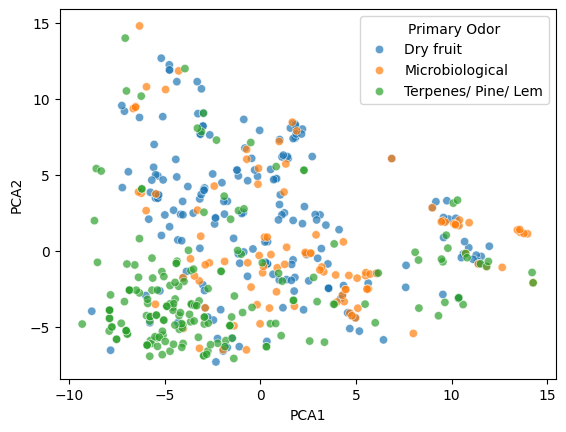

In [ ]:
sns.scatterplot(data=subsample_df, x='PCA1', y='PCA2', hue='Primary Odor', palette='tab10', alpha=0.7)

<Axes: xlabel='PCA1', ylabel='PCA2'>

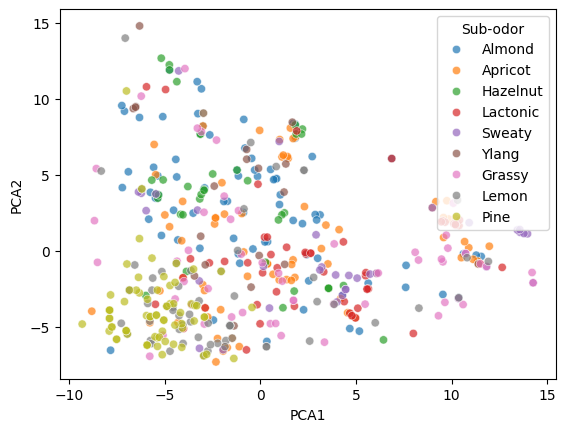

In [ ]:
sns.scatterplot(data=subsample_df, x='PCA1', y='PCA2', hue='Sub-odor', palette='tab10', alpha=0.7)

<ipython-input-60-f534e02fc668>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(primary_odors))


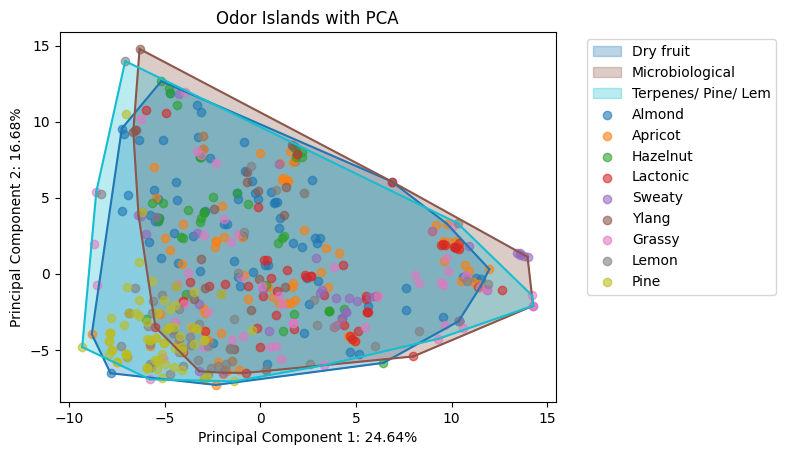

In [ ]:
def plot_convex_hull(points, label, color):
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=color)
    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.3, label=label)

# Get unique primary odors and assign colors
primary_odors = subsample_df['Primary Odor'].unique()
colors = plt.cm.get_cmap('tab10', len(primary_odors))

for i, primary_odor in enumerate(primary_odors):
    subset = subsample_df[subsample_df['Primary Odor'] == primary_odor]
    points = subset[['PCA1', 'PCA2']].values
    plot_convex_hull(points, primary_odor, colors(i))

# Scatter plot for sub-odors
for sub_odor in subsample_df['Sub-odor'].unique():
    subset = subsample_df[subsample_df['Sub-odor'] == sub_odor]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=sub_odor, alpha=0.6)

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend and labels
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.title('Odor Islands with PCA')
plt.show()

##DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
def filter_dense_regions(df, eps=0.8, min_samples=10):
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(df[['PCA1', 'PCA2']])
    df['cluster'] = clustering.labels_
    return df[df['cluster'] != -1]

# Filter the dataframe for dense regions for each primary odor
filtered_df_list = []
for primary_odor in subsample_df['Primary Odor'].unique():
    primary_df = subsample_df[subsample_df['Primary Odor'] == primary_odor]
    filtered_primary_df = filter_dense_regions(primary_df)
    filtered_df_list.append(filtered_primary_df)

filtered_df = pd.concat(filtered_df_list)
filtered_df

<ipython-input-75-ab48e0758af8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clustering.labels_
<ipython-input-75-ab48e0758af8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = clustering.labels_
<ipython-input-75-ab48e0758af8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

Sr. No         Primary Odor Sub-odor       CAS-Id  \
8      6189            Dry fruit   Almond      93-58-3   
13     6194            Dry fruit   Almond      98-86-2   
14     6195            Dry fruit   Almond     101-41-7   
18     6199            Dry fruit   Almond     104-50-7   
34     6215            Dry fruit   Almond    1192-62-7   
..      ...                  ...      ...          ...   
485   37984  Terpenes/ Pine/ Lem     Pine   72928-52-0   
487   37986  Terpenes/ Pine/ Lem     Pine   19902-08-0   
488   37987  Terpenes/ Pine/ Lem     Pine     473-62-1   
491   37990  Terpenes/ Pine/ Lem     Pine   81786-73-4   
492   37991  Terpenes/ Pine/ Lem     Pine  479547-57-4   

                                        Chemical name  \
8                                     Methyl benzoate   
13                                       Acetophenone   
14                               Methyl phenylacetate   
18                                  gamma-Octalactone   
34                                      2-Acetylfuran   
..                                                ...   
485                                  Myrtenyl formate   
487                                   (+)-beta-Pinene   
488                                      (+)-Pinanone   
491          (Z)-3,4,5,6,6-Pentamethylhept-3-en-2-one   
492  trans-And cis-2,4,8-Trimethyl-3,7-nona-dien-2-ol   

                          SMILES          standardized_smiles  \
8             COC(=O)C1=CC=CC=C1              COC(=O)c1ccccc1   
13             CC(=O)C1=CC=CC=C1               CC(=O)c1ccccc1   
14           COC(=O)CC1=CC=CC=C1             COC(=O)Cc1ccccc1   
18               CCCCC1CCC(=O)O1              CCCCC1CCC(=O)O1   
34               CC(=O)C1=CC=CO1                CC(=O)c1ccco1   
..                           ...                          ...   
485      CC1(C2CC=C(C1C2)COC=O)C      CC1(C)C2CC=C(COC=O)C1C2   
487          CC1(C2CCC(=C)C1C2)C            C=C1CCC2CC1C2(C)C   
488         CC1C2CC(C2(C)C)CC1=O         CC1C(=O)CC2CC1C2(C)C   
491  CC(C(=C(C)C(=O)C)C)C(C)(C)C  CC(=O)C(C)=C(C)C(C)C(C)(C)C   
492      CC(=CCCC(=CC(C)(C)O)C)C      CC(C)=CCCC(C)=CC(C)(C)O   

                                             embedding      PCA1      PCA2  \
8    [0.53460675, 1.0654953, -0.07191992, -0.404552...  1.708801  8.360724   
13   [0.5165619, 1.0408413, -0.10625382, -0.4728805...  1.825094  8.328466   
14   [0.70440924, 1.3043242, 0.18592009, -0.0653288...  1.825918  7.409151   
18   [0.7683881, -0.049969397, -0.49885672, -0.3965...  9.624884  1.949786   
34   [0.77258027, 1.3576381, 0.07646536, -0.5311758...  1.901681  7.880105   
..                                                 ...       ...       ...   
485  [0.9729834, 0.7145519, 0.3847119, -0.3135523, ... -5.287435 -5.681092   
487  [1.1788402, 0.35404998, 0.5242649, -0.71296984... -7.015639 -5.256500   
488  [0.9930867, 0.18080057, 0.12273232, -0.6336326... -3.329005 -3.608680   
491  [0.8530609, 0.09721568, 0.656752, -0.87536883,... -4.972471 -5.961092   
492  [0.8587807, 0.16104291, 0.57246244, -1.0304945... -4.540086 -6.145646   

     cluster  
8          1  
13         1  
14         1  
18         0  
34         1  
..       ...  
485        2  
487        1  
488        0  
491        2  
492        2  

[87 rows x 11 columns]

<Axes: xlabel='PCA1', ylabel='PCA2'>

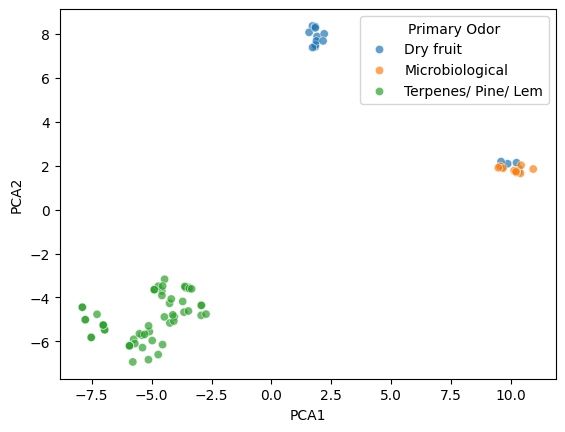

In [ ]:
sns.scatterplot(data=filtered_df, x='PCA1', y='PCA2', hue='Primary Odor', palette='tab10', alpha=0.7)

<Axes: xlabel='PCA1', ylabel='PCA2'>

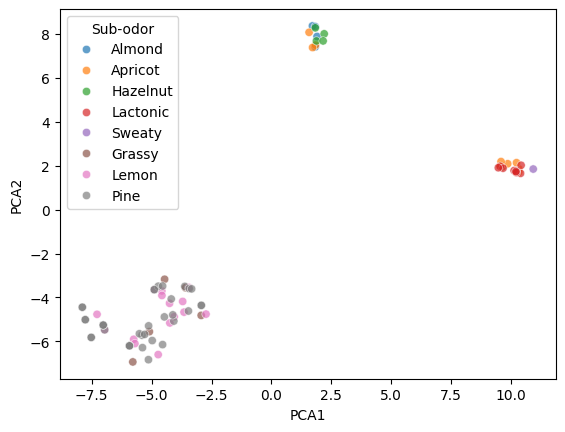

In [ ]:
sns.scatterplot(data=filtered_df, x='PCA1', y='PCA2', hue='Sub-odor', palette='tab10', alpha=0.7)

<ipython-input-80-90ca181c89c3>:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(primary_odors))


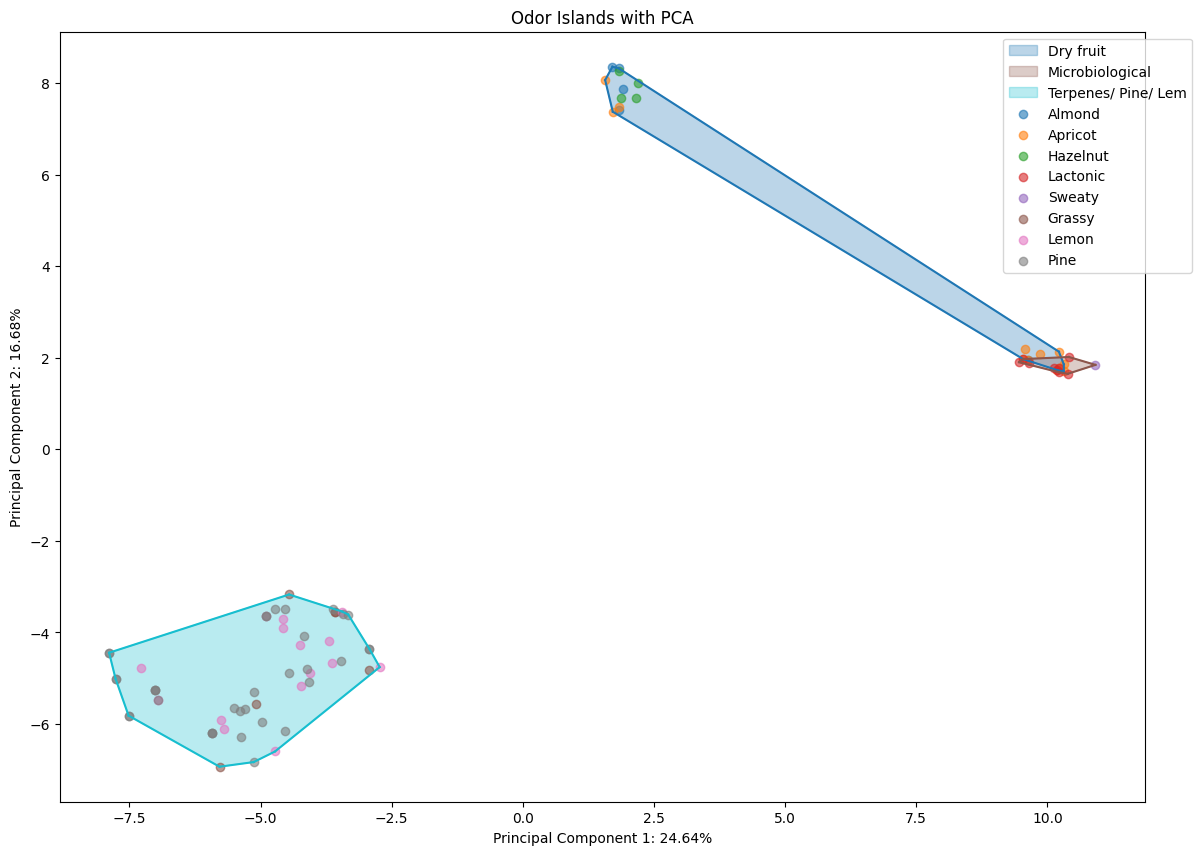

In [ ]:
plt.figure(figsize=(14, 10))
def plot_convex_hull(points, label, color):
    hull = ConvexHull(points)
    for simplex in hull.simplices:
        plt.plot(points[simplex, 0], points[simplex, 1], color=color)
    plt.fill(points[hull.vertices, 0], points[hull.vertices, 1], color=color, alpha=0.3, label=label)

# Get unique primary odors and assign colors
primary_odors = filtered_df['Primary Odor'].unique()
colors = plt.cm.get_cmap('tab10', len(primary_odors))

for i, primary_odor in enumerate(primary_odors):
    subset = filtered_df[filtered_df['Primary Odor'] == primary_odor]
    points = subset[['PCA1', 'PCA2']].values
    plot_convex_hull(points, primary_odor, colors(i))

# Scatter plot for sub-odors
for sub_odor in filtered_df['Sub-odor'].unique():
    subset = filtered_df[filtered_df['Sub-odor'] == sub_odor]
    plt.scatter(subset['PCA1'], subset['PCA2'], label=sub_odor, alpha=0.6)

explained_variance_ratio = pca.explained_variance_ratio_
pc1_variance = explained_variance_ratio[0] * 100
pc2_variance = explained_variance_ratio[1] * 100

# Add legend and labels
plt.legend(loc='best', bbox_to_anchor=(1.05, 1), ncol=1)
plt.xlabel(f'Principal Component 1: {pc1_variance:.2f}%')
plt.ylabel(f'Principal Component 2: {pc2_variance:.2f}%')
plt.title('Odor Islands with PCA')
plt.show()